In [1]:
datetag = None

In [2]:
datetag = '2023-09-27'

In [3]:
if datetag is None:
    from time import strftime, gmtime
    datetag = strftime("%Y-%m-%d", gmtime())
print(f"datetag='{datetag}'")

datetag='2023-09-27'


# HD-SNN: Accurate detection of spiking motifs in multi-unit raster plots


We design a model based on heterogeneous delays. We will define in the assembly of neurons where each synapse
is defined by a weight *ws* at different delays *τs*. See the following figure: 

In [4]:
# %pip install -U pip pandas
# uncomment for MacOS with silicon M1
# %pip install -U --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cpu

In [5]:
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# device = torch.device('cpu') # uncomment to force CPU usage
device

device(type='mps')

In [6]:
import os
import numpy as np
phi = np.sqrt(5)/2 + 1/2
import matplotlib
import matplotlib.pyplot as plt

import matplotlib
subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

figpath = 'figures'
figpath = None

def printfig(fig, name, exts=['pdf', 'svg'], figpath=figpath, dpi_exp=None, bbox='tight'):
    for ext in exts:
        fig.savefig(os.path.join(figpath, name + '.' + ext), dpi=dpi_exp, bbox_inches=bbox, transparent=True)

if not(figpath is None): os.makedirs(figpath, exist_ok=True)

In [7]:
# https://docs.python.org/3/library/dataclasses.html?highlight=dataclass#module-dataclasses
from dataclasses import dataclass, asdict, field

@dataclass
class Params:
    datetag: str = datetag
    N_pre: int = 128 # number of presynaptic inputs
    N_SM_time: int = 31 # number of timesteps in SM, must be a odd number for convolutions
    N_SMs: int = 233 # number of spiking motifs
    E_SM: float = 4. # excitability range of SMs
    p_SM: float = .05 # ratio of non-zero coefficients in SMs
    T_trial: float = 1. # time duration of a trial (in second)
    tau_decay: float = .4 # time constant for the decay of the SM enveloppe (in second)
    tau_rise: float = .05 # time constant for the rise of the SM enveloppe (in second)

    ## Raster plots
    N_time: int =  2**10 # number of timebins for the raster plot
    N_trials: int = 10 # number of trials
    p_B: float = .001 # prior probability of firing for postsynaptic raster plot (spike per timebin)
    p_A: float = .001 # prior probability of firing for presynaptic raster plot (spike per timebin)
    seed: int = 42 # seed

    ## figures
    verbose: bool = False # Displays more verbose output.
    fig_width: float = 12 # width of figure
    phi: float = 1.61803 # beauty is gold
    N_SM_show: int = 5 # number of SM to show in plot_SM


In [8]:
opt = Params()
opt

Params(datetag='2023-09-27', N_pre=128, N_SM_time=31, N_SMs=233, E_SM=4.0, p_SM=0.05, T_trial=1.0, tau_decay=0.4, tau_rise=0.05, N_time=1024, N_trials=10, p_B=0.001, p_A=0.001, seed=42, verbose=False, fig_width=12, phi=1.61803, N_SM_show=5)

### generative & inference models for spiking motifs (SM)

In [9]:
class ABCD:

    def __init__(self, opt):
        self.opt: Params = opt
        self.init()

    def init(self):
        """
        
        initializes "temporal mod", which governs the overall structure of the motif. 
        The shape is the product  of two exponenential functions creating a "psp-like" 
        shape. in set_SM the temporal mod will cause each SM to have the 
        distribution shape of temporal mod, such that the probability distribution 
        of spike occurences has a fast rise and a slow decay.

        """
        self.logit_p_A = torch.logit(torch.tensor(self.opt.p_A))

        temporal_mod = torch.zeros(self.opt.N_SM_time)
        self.time = torch.linspace(0, self.opt.T_trial, self.opt.N_time)
        self.SM_time = torch.linspace(0, self.opt.T_trial, self.opt.N_SM_time)
        temporal_mod = torch.exp(- self.SM_time / self.opt.tau_decay)
        temporal_mod *= 1 - torch.exp(- self.SM_time / self.opt.tau_rise)
        # temporal_mod = temporal_mod.flip([0])
        #self.temporal_mod = (torch.eye(self.opt.N_SMs).unsqueeze(2)) * (temporal_mod.unsqueeze(0).unsqueeze(0))
        self.temporal_mod = torch.ones((self.opt.N_pre, self.opt.N_SMs, 1)) * (temporal_mod.unsqueeze(0).unsqueeze(0))
        
        """
        torch.eye -> identity matrix 
        torch.unsqueeze -> wrap in more brackets
        torch.flip -> reverses the orders of the elements in the vector
        
        this creates a 144 by 144 by 3 matrix, 
        Then at each diagonal there is an identical spike waveform
        such that convolving the SM with that matrix will result in a
        spike waveform at each presynptic input.
        
        """
        spike = torch.tensor([1, -.8, -.2]) # spike shape with depolariation (1) and hyperpolarization ([-.8, -.2])
        self.spike = (torch.eye(self.opt.N_SMs).unsqueeze(2)) * (spike.flip([0]).unsqueeze(0).unsqueeze(0))


    def set_SM(self, seed=None, seed_offset=0):
        """
        Returns a N_SMs by N_pre by N_SM_time dimensional matrix representing the probability distribution of each elemenet
        in the matrix to evoke a spike. Presumably later spikes will be drawn from this distribution via Bernoulli trials.
        """
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        
        # 1/ define SMs as matrices to be used as kernels
        SM = self.opt.E_SM * torch.randn(self.opt.N_pre, self.opt.N_SMs, self.opt.N_SM_time)
        #threshold = torch.abs(SM).quantile(1-self.opt.p_SM)

        # 2/ zero out everything below the threshold
        # TODO : get analytically
        from scipy.stats import norm
        threshold = self.opt.E_SM * norm.ppf(1-self.opt.p_SM)
        SM *= (SM > threshold)

        # 3/ modulate in time
        SM *= self.temporal_mod

        # 4/ convolve with a spike shape to induce some sort of refractory period
        SM = torch.conv1d(SM, self.spike, padding=self.spike.shape[-1]//2)
        return torch.swapaxes(SM, 0, 1)

    def get_b(self, seed=None, seed_offset=1):
        """
        generates a matrix of events for each SM, for each trial, returns a matrix of N_trials, N_SMs, N_time, 
        draw causes (SMs) as a matrix of sparse SM activations uniformly in postsynaptic space and time
        
        """
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        
        # we set it to zero everywhere
        b_proba = torch.zeros(self.opt.N_trials, self.opt.N_SMs, self.opt.N_time)
        # set to p_B except outside the borders
        b_proba[:, :, (self.opt.N_SM_time//2):-(self.opt.N_SM_time//2)] = self.opt.p_B        
        return torch.bernoulli(b_proba)

    def plot_raster(self, raster, raster_post=None, SM=None, 
                    i_trial=0, shift=0, xticks=6, yticks=16, spikelength=.9, 
                    colors=None, figsize=None, subplotpars=subplotpars, 
                    ylabel='address', linewidths=1.0):
        """    
        plots b, which is trials by M by T
        """

        N_neurons = raster.shape[1]
        if colors is None: # blue if nothing assigned
            colors = ['b'] * N_neurons
        else: # give the colors or ...
            if len(colors)==1: # ... paint everything the same color
                colors = colors[0] * N_neurons

        if figsize is None: figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)

        fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
        if raster_post is None:
            for i in range(0, N_neurons):
                ax.eventplot(np.where(raster[i_trial, i, :] == 1.)[0]+shift, 
                    colors=colors[i], lineoffsets=1.*i+spikelength/2, 
                    linelengths=spikelength, linewidths=linewidths)
        else:
            for i_SM in range(self.opt.N_SMs):
                b_ = torch.zeros_like(raster_post)
                b_[i_trial, i_SM, :] = raster_post[i_trial, i_SM, :]
                a_ = self.draw_a(b_, SM)
                for i in range(0, self.opt.N_pre):
                    ax.eventplot(np.where(a_[i_trial, i, :] == 1.)[0]+shift, colors=colors[i_SM], lineoffsets=1.*i+spikelength/2, 
                    linelengths=spikelength, linewidths=linewidths)
    
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time (a. u.)')
        ax.set_xlim(0, self.opt.N_time)
        ax.set_ylim(0, N_neurons)

        # ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(yticks))
        ax.set_yticks(np.linspace(0, N_neurons, yticks, endpoint=False)+.5)
        ax.set_yticklabels(np.linspace(1, N_neurons, yticks, endpoint=True).astype(int))
        for side in ['top', 'right']: ax.spines[side].set_visible(False)
        
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(4))
        ax.set_xticks(np.linspace(1, self.opt.N_time, xticks, endpoint=True))
        ax.set_xticklabels(np.linspace(1, self.opt.N_time, xticks, endpoint=True).astype(int))

        ax.grid(visible=True, axis='y', linestyle='-', lw=.5)
        ax.grid(visible=True, axis='x', which='both', linestyle='-', lw=.1)

        return fig, ax


    def plot_b(self, b, i_trial=0, xticks=6, yticks=16, spikelength=.9, colors=None, figsize=None, subplotpars=subplotpars):
        # b_shifted = torch.roll(b, -self.opt.N_SM_time//2, dims=-1)
        b_shifted = torch.roll(b, 0, dims=-1) # HACK

        fig, ax = self.plot_raster(raster=b_shifted, i_trial=i_trial, xticks=xticks, yticks=yticks, spikelength=spikelength, colors=colors, figsize=figsize, subplotpars=subplotpars, ylabel='@ Motif')
        return fig, ax

    def model_a_logit(self, b, SM):
        """

        Generative model:
        defines the evidence of firing for each presynaptic address over time
        returns the logit_p_A rasters for each trial

        input b -> postsynaptic raster plot
            SM -> spiking motifs as spatio temporal kernels
            p_A -> prior proba of firing for the presynaptic addresses
        
        """
        logit_p_A_fromB = torch.conv_transpose1d(b*1., SM, padding=self.opt.N_SM_time//2)
        return self.logit_p_A + logit_p_A_fromB

    def model_a(self, b, SM):
        """

        Generative model:
        defines the probability of firing for each presynaptic address over time from its evidence

        calls model_a_logit(b,SM) to get the logit, and applies the sigmoid over the logit_p_A rasters to turn the 
        rasters into probabilities between 1 and 0        
        """
        logit_A = self.model_a_logit(b, SM)
        return torch.sigmoid(logit_A)

    def draw_a(self, b, SM, seed=None, seed_offset=2):
        """
        calls model_a(b,SM) and generates A_proba which is the probability distribution of neuron spiking events,
        then this gets passed through a bernoulli trial, deciding where neurons spike given the probability distribution
        """
        # draws binary events from the probability of firing
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        # generate the corresponding raster plot
        A_proba = self.model_a(b, SM)
        return torch.bernoulli(A_proba)

    def plot_a(self, a, b=None, SM=None, i_trial=0, shift=0, xticks=6, yticks=16, spikelength=.9, colors=None, figsize=None, subplotpars=subplotpars):
        fig, ax = self.plot_raster(raster=a, raster_post=b, SM=SM, i_trial=i_trial, shift=shift,
                                   xticks=xticks, yticks=yticks, spikelength=spikelength, colors=colors, 
                                   figsize=figsize, subplotpars=subplotpars, ylabel='@ Neuron')
        return fig, ax

    def do_thresholding(self, b, p_B, max_quant=10000000):
        """

        Threshold model:

        essentially this function transforms the convoluted matrix which is unnormalized and unbounded into
        a matrix of quantiles, and then binarizes the matrix by thresholding. The function returns the 
        binary b matrix...
        
        """
        if len(b.ravel()) > max_quant: # the quantile function does not like having to many samples
            ind_quant = torch.randperm(len(b.ravel()))[:max_quant]
            b_threshold = torch.quantile(b.ravel()[ind_quant], 1-p_B)
        else:
            b_threshold = torch.quantile(b, 1-p_B)

        b_hat_bin = (b > b_threshold) * 1.
        return b_hat_bin

    def inference_with_SMs(self, a, b, SM, max_quant=10000000, method='HD-SNN'):
        """

        Detection model:
        defines the probability of firing for each postsynaptic address over time
        

        convolutes matrix a with matrix SM and returns another matrix of the same size as b. Since SM
        isn't binary, b_hat also isn't binary... Therefore to turn b_hat back into a binary image the 
        the function do_thresholding get's called. both b_hat and b_hat_bin get returned.

        """
        # infer 
        if not(method=='HD-SNN'):
            SM = torch.sigmoid(self.logit_p_A +  SM)
            # SM = (SM > SM.std())*1. - (SM < -SM.std())*1.

        b_hat = torch.conv1d(a*1., SM, padding=self.opt.N_SM_time//2)
        # decision
        p_B = b.sum()/(self.opt.N_trials*self.opt.N_SMs*self.opt.N_time) 
        # hack: ça suppose qu'on connait b.sum()...
        b_hat_bin = self.do_thresholding(b_hat, p_B, max_quant=max_quant)
        return b_hat, b_hat_bin
    
    def generative_model(self, seed=None, seed_offset=3):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        SM, b = self.set_SM(seed=seed), self.get_b(seed=seed+1)
        a = self.draw_a(b, SM, seed=seed+2)
        return a, b, SM

    def test_model(self, SM, SM_true=None, seed=None, seed_offset=4, method='HD-SNN'):
        """
        this function calls inference_with_SMs(a,b,SM). This function calls get_b and draw_a over again, so 
        if this method is called it will reset the raster plot given SM... ( i think?)... hmmmmm
        Or maybe SM are the priors?   
        
        """
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        if SM_true is None: SM_true = SM
        # define SMs
        # draw causes (SMs)
        b = self.get_b(seed=seed)
        # generate the corresponding raster plot
        a = self.draw_a(b, SM_true, seed=seed+1)
        # infer 
        _, b_hat_bin = self.inference_with_SMs(a, b, SM, method=method)
        # count
        accuracy = torch.mean((b_hat_bin == b)*1.)
        TP = torch.mean(b_hat_bin[b==1]*1.)
        TN = 1-torch.mean(b_hat_bin[b==0]*1.)
        return accuracy, TP, TN
        
    def plot_SM(self, SM, cmap='seismic', colors=None, aspect=None, figsize=None, subplotpars=subplotpars, N_SM_show: int=0):

        if N_SM_show == 0: N_SM_show = self.opt.N_SM_show
        if SM.dtype == torch.bool:
            SM_max = 1
            SM_min = 0
            cmap = 'binary'
        else:
            # SM = SM.numpy()
            SM_max = np.abs(SM).max()#.item()
            SM_min = -SM_max

        if figsize is None: figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)

        fig, axs = plt.subplots(1, N_SM_show, figsize=figsize, subplotpars=subplotpars)
        for i_SM in range(N_SM_show):
            ax = axs[i_SM]
            ax.set_axisbelow(True)

            ax.pcolormesh(SM[i_SM, :, :], cmap=cmap, vmin=SM_min, vmax=SM_max)
            #ax.imshow(SM[:, i_SM, :], cmap=cmap, vmin=SM_min, vmax=SM_max, interpolation='none')
            
            ax.set_xlim(0, SM.shape[2])

            ax.set_xlabel('Delay')
            # ax.set_title(f'Motif {i_SM+1}', color='k' if colors is None else colors[i_SM])
            # ax.text(-25, -.2*self.opt.N_pre, f'#{i_SM+1}', color='k' if colors is None else colors[i_SM])
            t = ax.text(.40*self.opt.N_SM_time, .95*self.opt.N_pre, f'SM #{i_SM+1}', color='k' if colors is None else colors[i_SM])
            t.set_bbox(dict(facecolor='white', edgecolor='white'))
            if not aspect is None: ax.set_aspect(aspect)

            ax.set_ylim(0, self.opt.N_pre)
            ax.set_yticks(np.arange(0, self.opt.N_pre, 1)+.5)
            if i_SM>0: 
                ax.set_yticklabels([])
            else:
                ax.set_yticklabels(np.arange(0, self.opt.N_pre, 1)+1)

            for side in ['top', 'right']: ax.spines[side].set_visible(False)
            #ax.set_xticks([0, self.opt.N_SM_time//2, self.opt.N_SM_time-1])
            ax.set_xticks([1, self.opt.N_SM_time//3, (self.opt.N_SM_time*2)//3, self.opt.N_SM_time-1])
            # ax.set_xticklabels([0, (self.opt.N_SM_time//2), (self.opt.N_SM_time)])
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(self.opt.N_SM_time//4))
            #ax.xaxis.set_minor_locator(AutoMinorLocator(4))
            #ax.set_xticklabels([-(self.opt.N_SM_time//2), 0, self.opt.N_SM_time//2])
            # ax.grid(True, axis='y', linestyle='-', lw=1)
            # ax.grid(True, axis='x', which='both', linestyle='-', lw=.1)

        axs[0].set_ylabel('@ Neuron')
        return fig, axs

    def plot_a_histo(self, a,  xticks=1, spikelength=.9, colors=None, figsize=None, subplotpars=subplotpars):
        if figsize is None: figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)

        fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
        ax.step(np.arange(self.opt.N_pre), a.numpy().mean(axis=(0, 2)), label='firing rate')
        ax.hlines(self.opt.p_A, 0, self.opt.N_pre, linestyles='--', color='orange', label='probability of firing for each address')
        ax.set_xlabel('address')
        ax.set_ylim(0)
        ax.legend()
        return fig, ax

    def plot_inference(self, b, b_hat, b_hat_bin, i_trial = 0, t_min = 100, t_max = 150, figsize=None, subplotpars=subplotpars):
        if figsize is None: figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)
        fig, ax = plt.subplots(1, 3, figsize=figsize, subplotpars=subplotpars)
        ax[2].imshow(b_hat_bin[i_trial, :, t_min:t_max])
        ax[0].imshow(b[i_trial, :, t_min:t_max])
        ax[1].imshow(b_hat[i_trial, :, t_min:t_max])
        return fig, ax

    def plot_inference_histo(self, b_hat, nb_bins = 100, figsize=None, subplotpars=subplotpars):
        if figsize is None: figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)

        fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
        ax.hist(b_hat.numpy().ravel(), bins=nb_bins)
        ax.set_ylabel('smarts')
        ax.set_xlabel('value of b_hat')
        ax.set_yscale('log')
        return fig, ax


In [10]:
env = ABCD(opt)

In [11]:
env.opt

Params(datetag='2023-09-27', N_pre=128, N_SM_time=31, N_SMs=233, E_SM=4.0, p_SM=0.05, T_trial=1.0, tau_decay=0.4, tau_rise=0.05, N_time=1024, N_trials=10, p_B=0.001, p_A=0.001, seed=42, verbose=False, fig_width=12, phi=1.61803, N_SM_show=5)

#### dev sandox

In [12]:
len(env.spike)//2, env.spike.shape

(116, torch.Size([233, 233, 3]))

In [13]:
env = ABCD(opt)
a, b, SM = env.generative_model()

In [14]:
env.spike.shape

torch.Size([233, 233, 3])

In [15]:
a.min(), a.max()

(tensor(0.), tensor(1.))

In [16]:
env.temporal_mod.shape

torch.Size([128, 233, 31])

In [17]:
SM.shape

torch.Size([233, 128, 31])

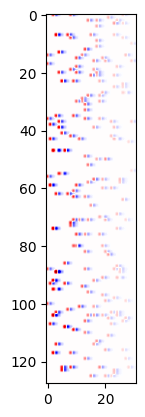

In [18]:
vmax = SM[0, :, :].abs().max()
plt.imshow(SM[0, :, :], cmap='seismic', vmin=-vmax, vmax=vmax)

# generative model for spiking motifs

In [19]:
opt = Params()
env = ABCD(opt)
a, b, SM = env.generative_model()
# env.plot_SM(SM);
# TODO find a better rule to generate SMs

Draw one instance of single SMs:

Draw the occurrences of SMs:

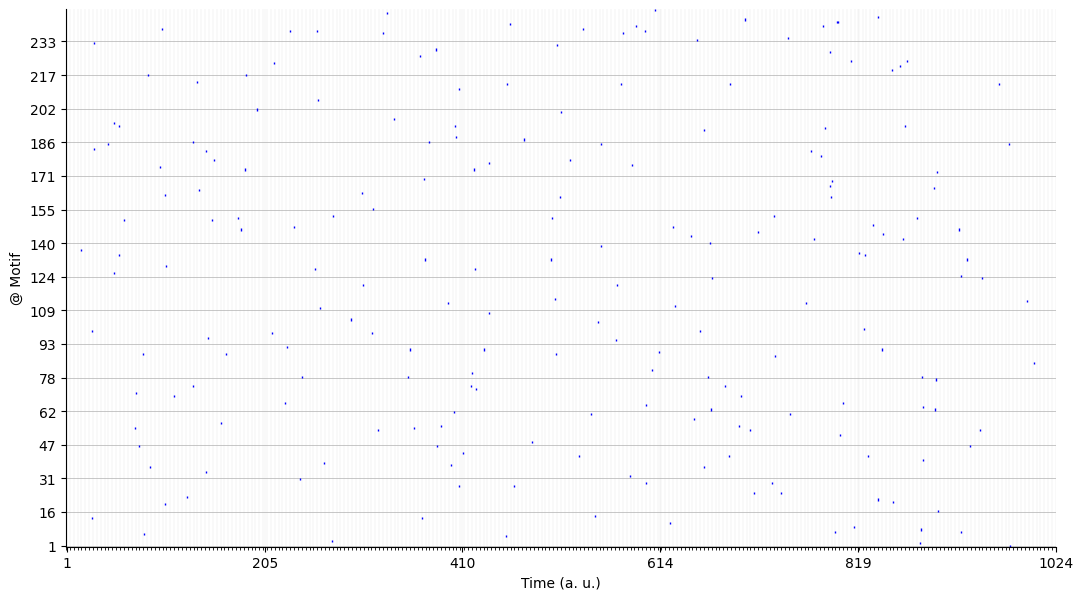

In [20]:
env.plot_b(b);

Resulting raster plot:

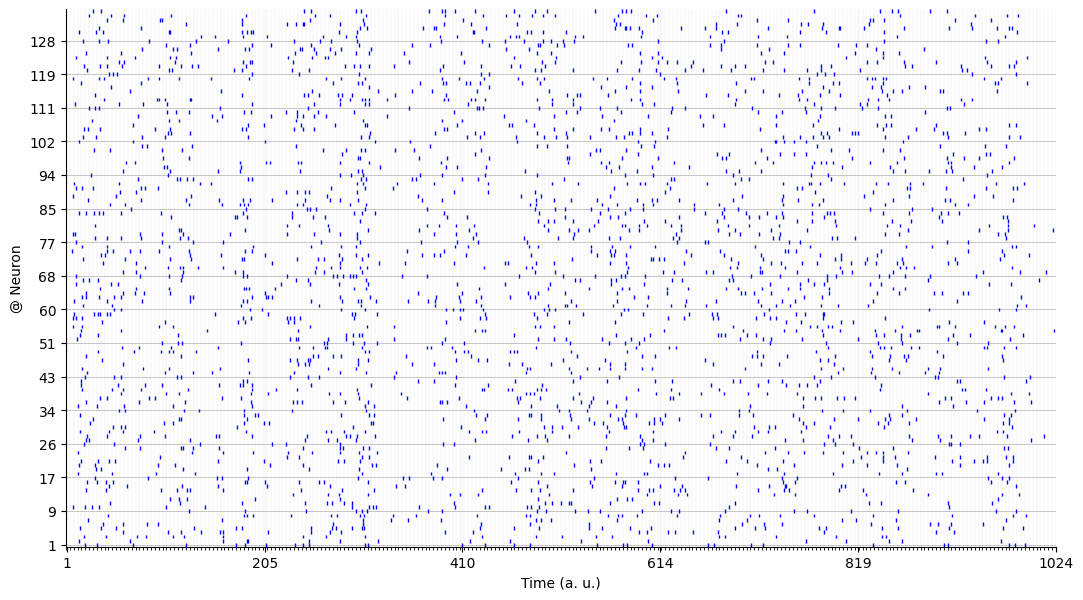

In [21]:
env.plot_a(a, i_trial=7);
# TODO correct this firing rate

TODO: circular padding?

In [22]:
a.mean(), b.mean(), b.mean(axis=(0, -1))[:20]

(tensor(0.020),
 tensor(0.001),
 tensor([0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
         0.001]))

# inference model for spiking motifs

knowing the raster plot `a`, let's try to infer `b` :

(<Figure size 1200x741.643 with 1 Axes>,
 <Axes: xlabel='value of b_hat', ylabel='smarts'>)

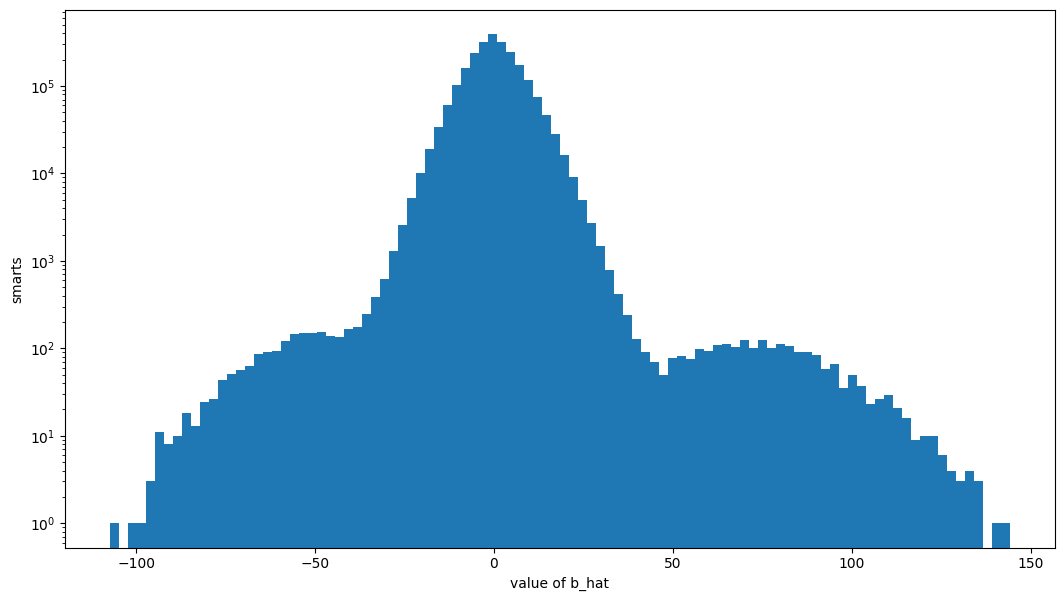

In [23]:
b_hat, b_hat_bin = env.inference_with_SMs(a, b, SM)
env.plot_inference_histo(b_hat)

(<Figure size 1200x741.643 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

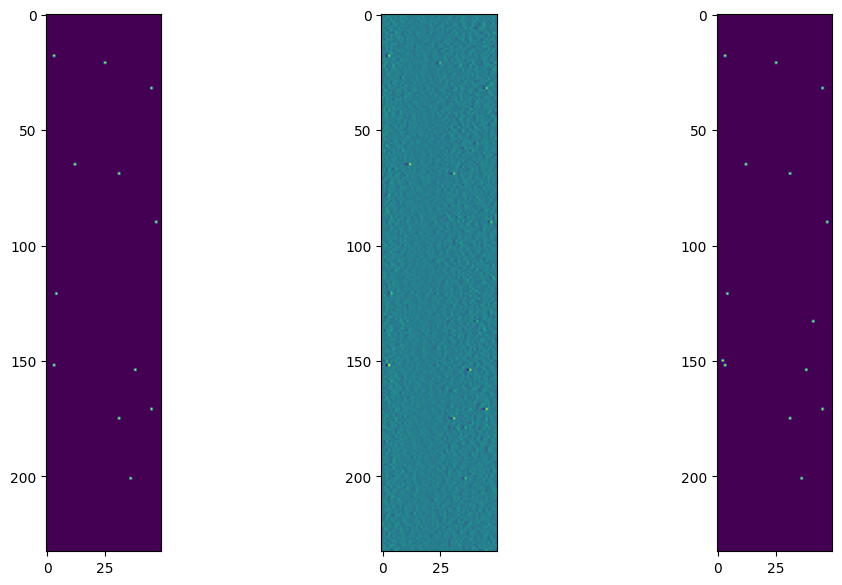

In [24]:
env.plot_inference(b, b_hat, b_hat_bin)

## test detection model, knowing the SMs

In [25]:
%%timeit
accuracy, TP, TN = env.test_model(SM, SM)

386 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
accuracy, TP, TN = env.test_model(SM, SM)
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.99%, TP=95.02%, TN=100.00%


In [27]:
%%timeit
accuracy, TP, TN = env.test_model(SM, SM, method='corr')

387 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
accuracy, TP, TN = env.test_model(SM, SM, method='corr')
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.96%, TP=77.75%, TN=99.98%


## Figure toy model

In [29]:
N_SMs = 4
opt_fig_toy = Params(
    datetag = datetag + '_fig1',
    N_pre = 10, 
    N_SMs = N_SMs,
    N_SM_time = 31,
    E_SM = 100.,
    p_SM = .02,
    p_A = 0.001,
    p_B = 0.001, # not relevant here as we select B below
    N_SM_show = N_SMs,
    N_trials = 1,
    N_time = 240,
    seed = 1973,
    fig_width = 3.25,
    )
                    
env_fig1 = ABCD(opt_fig_toy)
# a, b, SM = env_fig1.generative_model()
SM = env_fig1.set_SM(seed=opt_fig_toy.seed)
b = env_fig1.get_b(seed=opt_fig_toy.seed+1)

In [30]:
env_fig1.opt


Params(datetag='2023-09-27_fig1', N_pre=10, N_SM_time=31, N_SMs=4, E_SM=100.0, p_SM=0.02, T_trial=1.0, tau_decay=0.4, tau_rise=0.05, N_time=240, N_trials=1, p_B=0.001, p_A=0.001, seed=1973, verbose=False, fig_width=3.25, phi=1.61803, N_SM_show=4)

In [31]:
env_fig1.opt.N_pre, env_fig1.opt.N_SMs, env_fig1.opt.N_SM_time

(10, 4, 31)

In [32]:
subplotpars_fig1 = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0.20, hspace=0.0,)
colors = ['r', 'g' , 'b' , 'm']

In [33]:
b = torch.zeros(b.shape)
b[0, 0,  20] = True
b[0, 0,  89] = True
b[0, 1, 70] = True
b[0, 1, 104] = True
b[0, 1, 160] = True
b[0, 1, 197] = True
b[0, 2,  42] = True
b[0, 2, 130] = True
b[0, 3, 160] = True
b.shape

torch.Size([1, 4, 240])

In [34]:
SM.shape

torch.Size([4, 10, 31])

In [35]:
SM.mean(), SM.abs().max(), SM.min(), SM.max()

(tensor(0.004), tensor(221.585), tensor(-177.268), tensor(221.585))

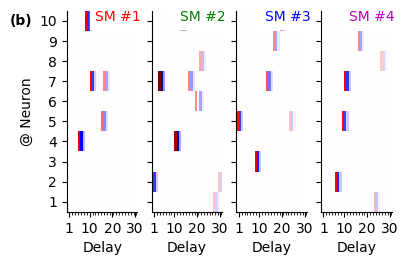

In [36]:
shift = -0.14
fig, axs = env_fig1.plot_SM(SM, colors=colors, subplotpars=subplotpars_fig1)
fig.text(shift, 0.95,'(b)', horizontalalignment='center', verticalalignment='center', weight='bold')
if not figpath is None: printfig(fig, 'THC_toy-b')
plt.show()

Then from the following raster plot, each SM described if the figure above will be selective to the spatio-temporal pattern of the same color: 

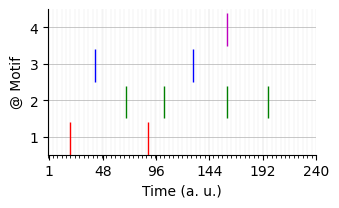

In [37]:
fig, ax = env_fig1.plot_b(b, colors=colors, yticks=env_fig1.opt.N_SMs)

In [38]:
a = env_fig1.draw_a(b, SM)

In [39]:
b_hat, b_hat_bin = env_fig1.inference_with_SMs(a, b, SM)


In [40]:
env_fig1.time.shape, a.shape, b_hat.shape, b_hat_bin.shape

(torch.Size([240]),
 torch.Size([1, 10, 240]),
 torch.Size([1, 4, 240]),
 torch.Size([1, 4, 240]))

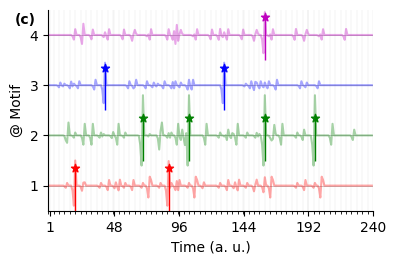

In [41]:
fig, ax = env_fig1.plot_b(b_hat_bin, colors=colors, subplotpars=subplotpars_fig1, yticks=env_fig1.opt.N_SMs)
fig.text(shift/2, 0.95,'(c)', horizontalalignment='center', verticalalignment='center', weight='bold')
b_hat_np = b_hat.squeeze(0).numpy()
b_hat_np /= np.abs(b_hat_np).max() / .8
for i_SM in range(env_fig1.opt.N_SMs):
    ax.plot(b_hat_np[i_SM, :]+i_SM+.5, color=colors[i_SM], alpha=.35)
    b_star = np.where(b[0, i_SM, :]==1)[0]
    ax.scatter(b_star, (i_SM+.85)*np.ones_like(b_star), color=colors[i_SM], marker='*')
if not figpath is None: printfig(fig, 'THC_toy-c')

It results in the following activation of the postsynaptic neurons (activation probability with a Bernoullin trial):

In [42]:
np.where(b[0, i_SM, :]==1)[0]

array([160])

In [43]:
env_fig1.opt.N_pre, a.shape, b.shape

(10, torch.Size([1, 10, 240]), torch.Size([1, 4, 240]))

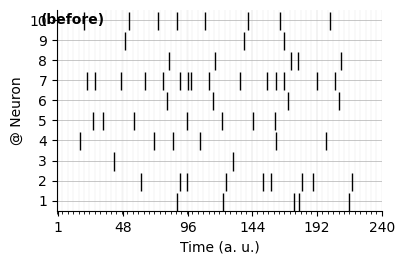

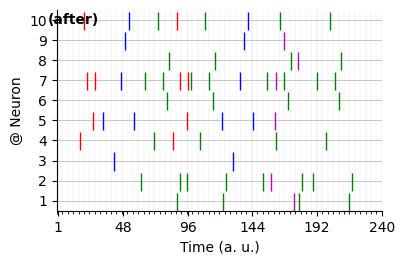

In [44]:
for suff in ['_k', '']:
    fig, ax = env_fig1.plot_a(a, b, SM, shift=env_fig1.opt.N_SM_time//4, # HACK
                              colors=colors if suff=='' else ['k'], subplotpars=subplotpars_fig1, yticks=env_fig1.opt.N_pre)
    
    if not figpath is None: 
        fig.text(shift, 0.95, '(a)' if suff=='_k' else '(d)', horizontalalignment='center', verticalalignment='center', weight='bold')
        printfig(fig, 'THC_toy-a' + suff)
    else:
        fig.text(0.05, 0.95,'(before)' if suff=='_k' else '(after)', horizontalalignment='center', verticalalignment='center', weight='bold')

    plt.show()

TODO: montrer des SMs générant des vagues, du bruit de Poisson, des one-spike per neuron, ...

## testing inference

In [45]:
env = ABCD(opt)
env.opt

Params(datetag='2023-09-27', N_pre=128, N_SM_time=31, N_SMs=233, E_SM=4.0, p_SM=0.05, T_trial=1.0, tau_decay=0.4, tau_rise=0.05, N_time=1024, N_trials=10, p_B=0.001, p_A=0.001, seed=42, verbose=False, fig_width=12, phi=1.61803, N_SM_show=5)

In [46]:
accuracy, TP, TN = env.test_model(SM=env.set_SM(seed=42), SM_true=env.set_SM(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.99%, TP=95.06%, TN=100.00%


In [47]:
accuracy, TP, TN = env.test_model(SM=env.set_SM(seed=42), SM_true=env.set_SM(seed=42), method='corr')
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.96%, TP=77.15%, TN=99.98%


## scanning parameters

In [48]:
data_cache = 'data_cache'
%mkdir -p {data_cache}

In [49]:
opt_scan = Params( datetag = datetag + '_scan',
                    N_time = 2**14,
                    fig_width = 3.25,
                    )
opt_scan.datetag

'2023-09-27_scan'

In [50]:
opt_scan.N_time

16384

In [51]:
%ls {data_cache}/{opt_scan.datetag}_*.json

data_cache/2023-09-27_scan_E_SM.json
data_cache/2023-09-27_scan_N_SM_time.json
data_cache/2023-09-27_scan_N_SMs.json
data_cache/2023-09-27_scan_N_pre.json
data_cache/2023-09-27_scan_p_A.json
data_cache/2023-09-27_scan_p_B.json
data_cache/2023-09-27_scan_p_SM.json
data_cache/2023-09-27_scan_tau_decay.json
data_cache/2023-09-27_scan_tau_rise.json


In [52]:
# %rm -f {data_cache}/{datetag}_scan_*.json

In [53]:
scan_dicts= {'N_SMs' : [8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1364, 2351],
             'N_SM_time' : [1, 3, 7, 15, 31, 63, 127],
             'N_pre' : [8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1364, 2351],
             'E_SM' : [1, 3, 7, 15, 31, 63, 127],
             'tau_decay':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
             'tau_rise':[0.01,0.05,0.1,0.2,0.5,0.9],
             # TODO : use geomspace
             'p_SM' : [k/1000 for k in [5, 10, 15, 25, 40, 65, 105, 170, 275, 445, 720, 1000]],
             'p_A':[0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.5],
             'p_B':[0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.5]             

            }

label_dicts= {'N_SMs' : 'number of motifs',
             'N_SM_time' : 'duration of motifs',
             'N_pre' : 'number of presynaptic inputs',
             'E_SM' : 'peak excitability of motifs',
             'p_SM' : 'sparsity of motifs',
             'tau_decay': 'time constant of decay',
             'tau_rise': 'time constant of rise',
             'p_A': 'apriori probability of firing for each presynaptic address',
             'p_B':  'apriori probability of firing for each motif',
            }
import os
import time
import pandas as pd
import numpy as np

N_cv = 10
seed = 1000 # np.random.randint(1000)
verb = False

for key in scan_dicts:
    filename = f'{data_cache}/{opt_scan.datetag}_{key}.json'
    print(f'{filename=}')
    if os.path.isfile(filename):
        df_scan = pd.read_json(filename)
    else:
        measure_columns = [key, 'accuracy', 'TP', 'TN', 'method', 'time']
        df_scan = pd.DataFrame([], columns=measure_columns)
        i_loc = 0
        for method in ['HD-SNN', 'corr']: 
            for i_value, value in enumerate(scan_dicts[key]):
                if verb: print('i_value', i_value + 1, ' /', len(scan_dicts[key]), end='\t')

                for i_cv in  range(N_cv):
                    # tic
                    since = time.time()
                    new_dict = asdict(opt)
                    # print(key, value)
                    new_dict[key] = value
                    new_opt = Params(**new_dict)
                    # print(new_opt)
                    # make a new model
                    new_env = ABCD(new_opt)
                    # draw a new set of SMs
                    SM = new_env.set_SM(seed=seed+i_loc)
                    # test it
                    accuracy, TP, TN = new_env.test_model(SM, SM, seed=seed+i_loc, method=method)
                    # toc
                    elapsed_time = time.time() - since
                    df_scan.loc[i_loc] = {key:value, 'accuracy':accuracy.item(), 'TP':TP.item(), 'TN':TN.item(), 'method':method, 'time':elapsed_time}
                    i_loc += 1
                    if verb: print(f" - One pass completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

        df_scan.to_json(filename)
    print(df_scan)

filename='data_cache/2023-09-27_scan_N_SMs.json'
     N_SMs  accuracy        TP        TN  method      time
0        8  0.999951  0.976744  0.999976  HD-SNN  0.063379
1        8  0.999951  0.974026  0.999976  HD-SNN  0.052444
2        8  0.999951  0.970149  0.999976  HD-SNN  0.048137
3        8  0.999829  0.919540  0.999914  HD-SNN  0.050146
4        8  0.999951  0.973684  0.999976  HD-SNN  0.049077
..     ...       ...       ...       ...     ...       ...
255   2351  0.998531  0.242215  0.999263    corr  7.554011
256   2351  0.998544  0.244475  0.999275    corr  6.927373
257   2351  0.998513  0.236915  0.999259    corr  6.687131
258   2351  0.998533  0.243135  0.999269    corr  6.627032
259   2351  0.998555  0.250875  0.999275    corr  7.680571

[260 rows x 6 columns]
filename='data_cache/2023-09-27_scan_N_SM_time.json'
     N_SM_time  accuracy        TP        TN  method      time
0            1  1.000000       NaN  1.000000  HD-SNN  0.069434
1            1  1.000000       NaN  1.00

Reading filename='data_cache/2023-09-27_scan_N_SMs.json'...
     N_SMs  accuracy        TP        TN  method      time
0        8  0.999951  0.976744  0.999976  HD-SNN  0.063379
1        8  0.999951  0.974026  0.999976  HD-SNN  0.052444
2        8  0.999951  0.970149  0.999976  HD-SNN  0.048137
3        8  0.999829  0.919540  0.999914  HD-SNN  0.050146
4        8  0.999951  0.973684  0.999976  HD-SNN  0.049077
..     ...       ...       ...       ...     ...       ...
255   2351  0.998531  0.242215  0.999263    corr  7.554011
256   2351  0.998544  0.244475  0.999275    corr  6.927373
257   2351  0.998513  0.236915  0.999259    corr  6.687131
258   2351  0.998533  0.243135  0.999269    corr  6.627032
259   2351  0.998555  0.250875  0.999275    corr  7.680571

[260 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


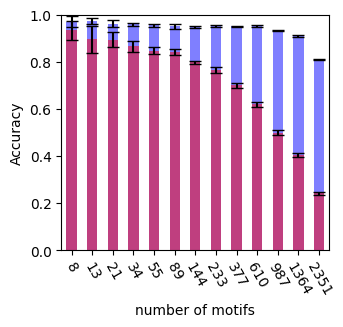

Reading filename='data_cache/2023-09-27_scan_N_SM_time.json'...
     N_SM_time  accuracy        TP        TN  method      time
0            1  1.000000       NaN  1.000000  HD-SNN  0.069434
1            1  1.000000       NaN  1.000000  HD-SNN  0.063933
2            1  1.000000       NaN  1.000000  HD-SNN  0.059802
3            1  1.000000       NaN  1.000000  HD-SNN  0.060135
4            1  1.000000       NaN  1.000000  HD-SNN  0.054192
..         ...       ...       ...       ...     ...       ...
135        127  0.999940  0.966430  0.999970    corr  0.859307
136        127  0.999954  0.973301  0.999977    corr  0.850763
137        127  0.999951  0.972048  0.999976    corr  0.839471
138        127  0.999953  0.973746  0.999977    corr  0.843567
139        127  0.999951  0.972443  0.999975    corr  0.892726

[140 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


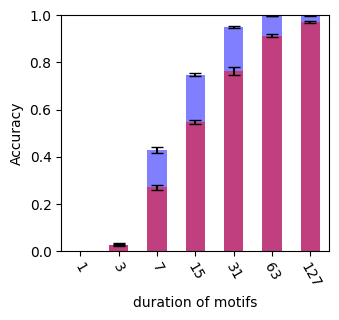

Reading filename='data_cache/2023-09-27_scan_N_pre.json'...
     N_pre  accuracy        TP        TN  method      time
0        8  0.998348  0.133626  0.999173  HD-SNN  0.150681
1        8  0.998264  0.128367  0.999131  HD-SNN  0.154906
2        8  0.998317  0.116146  0.999158  HD-SNN  0.142787
3        8  0.998338  0.127912  0.999169  HD-SNN  0.137957
4        8  0.998292  0.146923  0.999145  HD-SNN  0.156435
..     ...       ...       ...       ...     ...       ...
255   2351  0.999998  0.999143  0.999999    corr  2.499372
256   2351  0.999999  0.999553  1.000000    corr  2.534012
257   2351  1.000000  1.000000  1.000000    corr  2.531489
258   2351  0.999997  0.998680  0.999999    corr  2.543407
259   2351  0.999998  0.999138  0.999999    corr  2.536328

[260 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


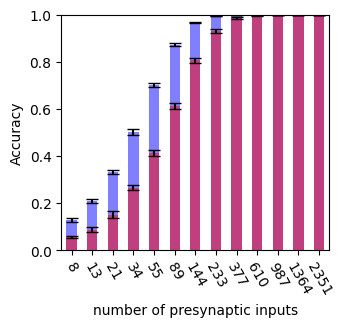

Reading filename='data_cache/2023-09-27_scan_E_SM.json'...
     E_SM  accuracy        TP        TN  method      time
0       1  0.998129  0.018901  0.999064  HD-SNN  0.334534
1       1  0.998049  0.020202  0.999023  HD-SNN  0.328397
2       1  0.998132  0.019358  0.999065  HD-SNN  0.336163
3       1  0.998114  0.010989  0.999056  HD-SNN  0.337661
4       1  0.998029  0.015906  0.999014  HD-SNN  0.348119
..    ...       ...       ...       ...     ...       ...
135   127  1.000000  1.000000  1.000000    corr  0.442675
136   127  1.000000  1.000000  1.000000    corr  0.449080
137   127  0.999999  0.999569  1.000000    corr  0.448772
138   127  0.999999  0.999574  1.000000    corr  0.441505
139   127  0.999999  0.999572  1.000000    corr  0.447610

[140 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


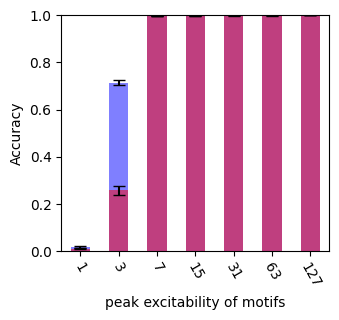

Reading filename='data_cache/2023-09-27_scan_tau_decay.json'...
     tau_decay  accuracy        TP        TN  method      time
0          0.1  0.998340  0.129670  0.999169  HD-SNN  0.378289
1          0.1  0.998241  0.116582  0.999119  HD-SNN  0.385068
2          0.1  0.998360  0.138583  0.999180  HD-SNN  0.385842
3          0.1  0.998337  0.127912  0.999168  HD-SNN  0.381018
4          0.1  0.998289  0.145668  0.999144  HD-SNN  0.381509
..         ...       ...       ...       ...     ...       ...
175        0.9  0.999955  0.976684  0.999977    corr  0.443320
176        0.9  0.999947  0.972173  0.999974    corr  0.442818
177        0.9  0.999941  0.970289  0.999971    corr  0.445000
178        0.9  0.999975  0.986882  0.999987    corr  0.445637
179        0.9  0.999962  0.980511  0.999981    corr  0.442980

[180 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


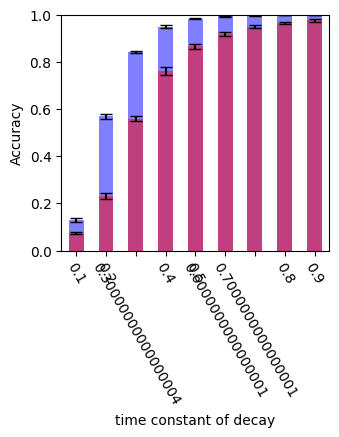

Reading filename='data_cache/2023-09-27_scan_tau_rise.json'...
     tau_rise  accuracy        TP        TN  method      time
0        0.01  0.999975  0.986813  0.999987  HD-SNN  0.443718
1        0.01  0.999967  0.983586  0.999984  HD-SNN  0.442027
2        0.01  0.999978  0.988561  0.999989  HD-SNN  0.442102
3        0.01  0.999982  0.990769  0.999991  HD-SNN  0.445676
4        0.01  0.999974  0.987024  0.999987  HD-SNN  0.445614
..        ...       ...       ...       ...     ...       ...
115      0.90  0.998065  0.005172  0.999032    corr  0.318829
116      0.90  0.998022  0.007569  0.999010    corr  0.322723
117      0.90  0.998081  0.005215  0.999040    corr  0.309788
118      0.90  0.998093  0.009146  0.999046    corr  0.308627
119      0.90  0.998077  0.008643  0.999038    corr  0.316173

[120 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


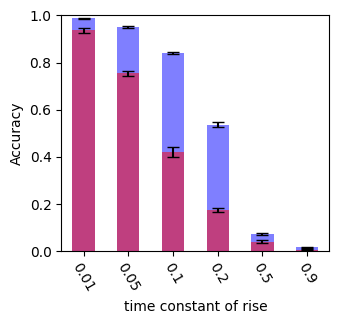

Reading filename='data_cache/2023-09-27_scan_p_SM.json'...
      p_SM  accuracy        TP        TN  method      time
0    0.005  0.999385  0.677363  0.999692  HD-SNN  0.249565
1    0.005  0.999379  0.688131  0.999689  HD-SNN  0.247990
2    0.005  0.999416  0.693357  0.999708  HD-SNN  0.258380
3    0.005  0.999425  0.698022  0.999712  HD-SNN  0.256826
4    0.005  0.999392  0.696526  0.999696  HD-SNN  0.259028
..     ...       ...       ...       ...     ...       ...
235  1.000  0.999815  0.904987  0.999907    corr  0.440625
236  1.000  0.999776  0.883406  0.999888    corr  0.447725
237  1.000  0.999769  0.881647  0.999884    corr  0.442866
238  1.000  0.999800  0.893966  0.999900    corr  0.447613
239  1.000  0.999764  0.877338  0.999882    corr  0.446120

[240 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


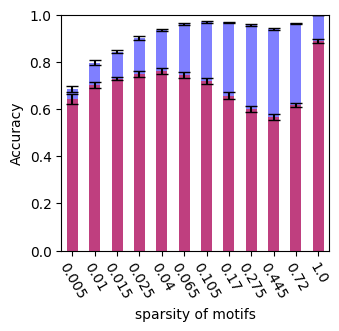

Reading filename='data_cache/2023-09-27_scan_p_A.json'...
       p_A  accuracy        TP        TN  method      time
0    0.001  0.999881  0.937582  0.999940  HD-SNN  0.446202
1    0.001  0.999896  0.947811  0.999948  HD-SNN  0.453300
2    0.001  0.999908  0.951606  0.999954  HD-SNN  0.445786
3    0.001  0.999910  0.952967  0.999955  HD-SNN  0.448156
4    0.001  0.999912  0.956049  0.999956  HD-SNN  0.446265
..     ...       ...       ...       ...     ...       ...
155  0.500  0.998546  0.253230  0.999273    corr  0.437053
156  0.500  0.998778  0.371552  0.999388    corr  0.441794
157  0.500  0.998800  0.392706  0.999399    corr  0.440919
158  0.500  0.998886  0.427895  0.999442    corr  0.440956
159  0.500  0.998717  0.323607  0.999358    corr  0.440026

[160 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


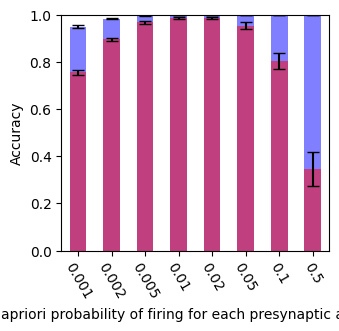

Reading filename='data_cache/2023-09-27_scan_p_B.json'...
       p_B  accuracy        TP        TN  method      time
0    0.001  0.999881  0.937582  0.999940  HD-SNN  0.442927
1    0.001  0.999896  0.947811  0.999948  HD-SNN  0.441032
2    0.001  0.999908  0.951606  0.999954  HD-SNN  0.447361
3    0.001  0.999910  0.952967  0.999955  HD-SNN  0.443855
4    0.001  0.999912  0.956049  0.999956  HD-SNN  0.452339
..     ...       ...       ...       ...     ...       ...
155  0.500  0.606247  0.594893  0.616983    corr  0.460322
156  0.500  0.605156  0.593365  0.616283    corr  0.447884
157  0.500  0.606234  0.594219  0.617558    corr  0.453909
158  0.500  0.603978  0.591834  0.615421    corr  0.450483
159  0.500  0.605717  0.593583  0.617148    corr  0.449912

[160 rows x 6 columns]
Bbox(x0=0.125, y0=0.25, x1=0.95, y1=0.975)


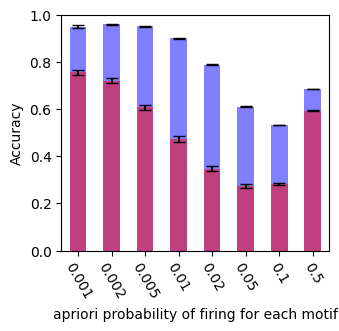

In [54]:
subplotpars_scan = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975)

for key in scan_dicts:
    filename = f'{data_cache}/{datetag}_scan_{key}.json'
    print(f'Reading {filename=}...')
    df_scan = pd.read_json(filename)
    print(df_scan)
    #for acc in ['TP', 'TN']
    #ax = df_scan.plot.scatter(x=key, y=['TP'], alpha=.1)
    #ax = df_scan.boxplot(column=key)
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html?highlight=errorbar#visualization-errorbars
    fig, ax = plt.subplots(figsize=(opt_scan.fig_width, opt_scan.fig_width), subplotpars=subplotpars_scan)
    for method, color in zip(['HD-SNN', 'corr'], ['b', 'r']):
        gp_scan = df_scan[df_scan['method']==method][[key, 'TP']].groupby([key])
        means = gp_scan.mean()
        errors = gp_scan.std()
        # means = np.array(gp_scan.mean()).squeeze()
        # errors = np.array(gp_scan.std()).squeeze()
        means.plot.bar(yerr=errors, ax=ax, capsize=4, rot=-60, legend=False, color=color, alpha=.5)
        # ax.errorbar(x=scan_dicts[key], y=means, yerr=errors, color=color, alpha=1, label=method)
    # ax.set_yscale("logit", one_half="1/2", use_overline=True)
    # ax.set_ylim(0.1, .99999)

    ax.set_ylabel('Accuracy')
    ax.set_xlabel(label_dicts[key])
    #ax.set_xscale('log')

    ax.set_ylim(0, 1)
    #fig = ax.get_figure()
    if not figpath is None: 
        printfig(fig, 'THC_' + key, figpath=figpath)

    pos = ax.get_position()
    print(pos)
    plt.show()

# Learning Spiking Motifs: supervised learning

## testing inference with wrong SMs 

In [55]:
opt_learn = Params( datetag = datetag + '_learn',
                    N_trials = 256,
                    seed = 2373,
                    fig_width = 4.5,
                    )

In [56]:
env = ABCD(opt_learn)
env.opt

Params(datetag='2023-09-27_learn', N_pre=128, N_SM_time=31, N_SMs=233, E_SM=4.0, p_SM=0.05, T_trial=1.0, tau_decay=0.4, tau_rise=0.05, N_time=1024, N_trials=256, p_B=0.001, p_A=0.001, seed=2373, verbose=False, fig_width=4.5, phi=1.61803, N_SM_show=5)

In [57]:
accuracy, TP, TN = env.test_model(SM=env.set_SM(seed=42), SM_true=env.set_SM(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.99%, TP=95.03%, TN=99.99%


In [58]:
accuracy, TP, TN = env.test_model(SM=env.set_SM(seed=51), SM_true=env.set_SM(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.81%, TP=0.23%, TN=99.90%


## learning 

In [59]:
(1-env.opt.p_B) / env.opt.p_B

999.0

In [60]:
DEBUG = 10
DEBUG = 1
def cachepath(data_cache, datetag, DEBUG):
    return os.path.join(data_cache, datetag +  f'_THC_DEBUG={DEBUG}')
cachepath(data_cache, datetag, DEBUG)

'data_cache/2023-09-27_THC_DEBUG=1'

In [61]:
env.opt

Params(datetag='2023-09-27_learn', N_pre=128, N_SM_time=31, N_SMs=233, E_SM=4.0, p_SM=0.05, T_trial=1.0, tau_decay=0.4, tau_rise=0.05, N_time=1024, N_trials=256, p_B=0.001, p_A=0.001, seed=2373, verbose=False, fig_width=4.5, phi=1.61803, N_SM_show=5)

In [62]:
target = torch.ones([10, 64, 100], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64, 100], 1.5)  # A prediction (logit)
# pos_weight = torch.ones([64, 100])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss() #pos_weight=pos_weight)
loss = criterion(output, target)  # -log(sigmoid(1.5))
loss

tensor(0.201)

In [63]:
SM_true = env.set_SM(seed=env.opt.seed)

class Net(torch.nn.Module):
    def __init__(self, N_pre, N_SMs, N_SM_time, bias=True):
        super(Net, self).__init__()
        self.N_pre, self.N_SMs, self.N_SM_time = N_pre, N_SMs, N_SM_time
        # https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose1d.html#torch.nn.ConvTranspose1d
        self.conv = torch.nn.Conv1d(self.N_pre, self.N_SMs, self.N_SM_time, 
                                              padding=self.N_SM_time//2, bias=bias)
        self.sigma = torch.nn.Sigmoid()

    def forward(self, a):
        # N_trials, N_pre, N_time = a.shape
        b_hat = self.conv(a*1.)
        # N_trials, N_SMs, N_time = b_hat.shape
        return self.sigma(b_hat)

lr = 0.0001 * DEBUG
lmbda = .01
N_learnsteps = 2**10 // DEBUG
# pos_weight = (1-env.opt.p_A) / env.opt.p_A

def learn_model(path, env, SM, SM_true, N_learnsteps=N_learnsteps, #pos_weight=pos_weight,
                #N_time=1000, # N_time_blur=200, 
                lmbda=lmbda, p_B=opt.p_B, do_stochastic=False, max_quant=10000000,
                lr=lr, seed=None, seed_offset=5, do_supervised=False):
    if seed is None: seed = opt.seed + seed_offset
    torch.manual_seed(seed)
    
    N_pre, N_SMs, N_SM_time = SM.shape

    # https://pytorch.org/docs/master/generated/torch.nn.BCEWithLogitsLoss.html   N_pre, N_SMs, N_SM_time
    criterion = torch.nn.BCEWithLogitsLoss() #pos_weight=torch.tensor([pos_weight])) #  * torch.ones((N_SM_time, N_SMs))
    # https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
    # criterion = torch.nn.BCELoss()
    criterion_reg = torch.nn.BCELoss()

    model = Net(N_pre, N_SMs, N_SM_time)
    model = model.to(device)

    SM_true = SM_true.to(device)

    if os.path.isfile(path + '.pth'):
        model.load_state_dict(torch.load(path + '.pth', map_location=torch.device(device)))
        # TODO: record during training : df_train = pd.read_csv(path + '.csv')

    elif os.path.isfile(path + '.lock'):
        # we want to have a file but it's locked
        print(f'Path {path} is locked')
        return None, None 

    else:

        #optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        print(env.opt.N_SMs, env.opt.N_pre, env.opt.N_SM_time)
        for i_step in range(N_learnsteps):
            # draw causes (SMs) - hidden to the observer
            b_true = env.get_b(seed=seed+i_step).to(device)
            # generate the corresponding raster plot = what is observed
            a = env.draw_a(b_true, SM_true, seed=seed+i_step+1).to(device)
            # print('A', a.min().item(), a.max().item())

            # learn the SMs
            optimizer.zero_grad()
            if do_supervised: # supervised learning
                b_hat_bin = 1. * b_true
            else:
                b_hat = model(a)
                if do_stochastic:
                    b_hat_bin = torch.bernoulli(model(a))
                else:
                    if len(b_hat.ravel()) > max_quant:
                        ind_quant = torch.randperm(len(b_hat.ravel()))[:max_quant]
                        b_threshold = torch.quantile(b_hat.ravel()[ind_quant], 1-env.opt.p_B)
                    else:
                        b_threshold = torch.quantile(b_hat, 1-p_B)

                    b_hat_bin = (b_hat > b_threshold) * 1.
            
            # TODO: make a threshold per SM
            b_hat_bin = b_hat_bin.to(device)
            a_hat = env.model_a_logit(b_hat_bin, model.conv.weight).to(device)
            # print('A', a_hat.min().item(), a_hat.max().item(), a.min().item(), a.max().item())
            # print('B', b_hat.min().item(), b_hat.max().item(), b_hat_bin.min().item(), b_hat_bin.max().item())
            loss = criterion(a_hat, a)
            loss_reg = criterion_reg(b_hat_bin.mean(axis=(0, 2)), p_B*torch.ones(N_SMs).to(device))
            loss += lmbda * loss_reg
            
            loss.backward()
            optimizer.step()

            # b_hat = b_hat.cpu()
            # b_true = b_true.cpu()
            # b_hat_bin = b_hat_bin.to(device)
            if i_step % (N_learnsteps//64) == 0:
                print(f'Train Epoch [{i_step:06d}/{N_learnsteps:06d}]\tLoss: {loss.item():.3e}\t(reg: {loss_reg.item():.3e})\tAccuracy: {torch.mean((b_hat_bin == b_true)*1.):.3e}\tTP: {torch.mean(b_hat_bin[b_true==1]*1.):.3e}')

        torch.save(model.state_dict(), path + '.pth')

    return model

In [64]:
subplotpars_learn = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)


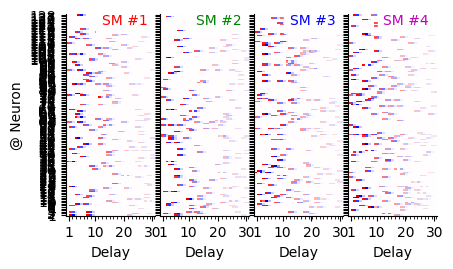

In [65]:
fig, axs = env.plot_SM(SM_true, colors=colors, N_SM_show=4, subplotpars=subplotpars_learn)

In [66]:
SM_start = env.set_SM(seed=51)
SM_start = env.opt.E_SM * torch.randn(env.opt.N_pre, env.opt.N_SMs, env.opt.N_SM_time)
N_pre, N_SMs, N_SM_time = SM_start.shape

model = Net(N_pre, N_SMs, N_SM_time)
print(N_pre, N_SMs, N_SM_time)

128 233 31


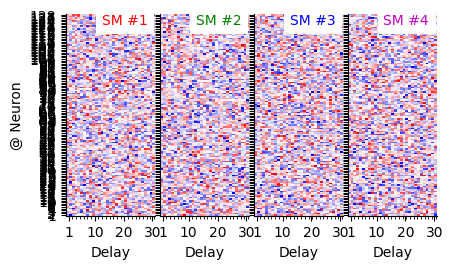

In [67]:
fig, axs = env.plot_SM(SM_start, colors=colors, N_SM_show=4, subplotpars=subplotpars_learn)

In [68]:
model = Net(N_pre, N_SMs, N_SM_time)

In [69]:
model.conv.weight.shape

torch.Size([233, 128, 31])

In [70]:
b_true = env.get_b(seed=seed).to(device)
# generate the corresponding raster plot = what is observed
a = env.draw_a(b_true, SM_true.to(device), seed=seed+1)
a.min(), a.max()

(tensor(0., device='mps:0'), tensor(1., device='mps:0'))

## Supervised Learning

In [71]:
%ls data_cache

2023-09-27_SL_THC_DEBUG=1.pth
2023-09-27_US_lr=1.00e-03_THC_DEBUG=1.pth
2023-09-27_US_lr=1.00e-05_THC_DEBUG=1.pth
2023-09-27_US_lr=1.58e-04_THC_DEBUG=1.pth
2023-09-27_US_lr=2.51e-05_THC_DEBUG=1.pth
2023-09-27_US_lr=3.98e-04_THC_DEBUG=1.pth
2023-09-27_US_lr=6.31e-05_THC_DEBUG=1.pth
2023-09-27_scan_E_SM.json
2023-09-27_scan_N_SM_time.json
2023-09-27_scan_N_SMs.json
2023-09-27_scan_N_pre.json
2023-09-27_scan_p_A.json
2023-09-27_scan_p_B.json
2023-09-27_scan_p_SM.json
2023-09-27_scan_tau_decay.json
2023-09-27_scan_tau_rise.json


In [72]:
model = learn_model(cachepath(data_cache, datetag + '_SL', DEBUG), env, SM_start, SM_true, do_supervised=True, N_learnsteps=N_learnsteps)

In [73]:
SM_hat = model.conv.weight.detach().cpu().numpy()
print(SM_hat.shape)
print(SM_hat.min(), SM_hat.mean(), SM_hat.max())
print(SM_true.min(), SM_true.mean(), SM_true.max())

(233, 128, 31)
-0.061568767 0.08482143 0.11774757
tensor(-8.854) tensor(0.000) tensor(10.350)


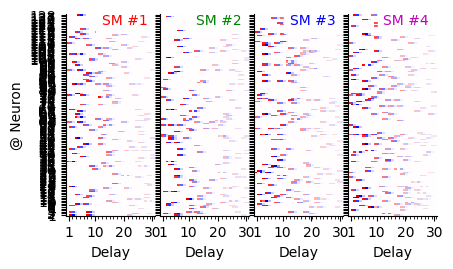

In [74]:
fig, axs = env.plot_SM(SM_true, colors=colors, N_SM_show=4, subplotpars=subplotpars_learn)

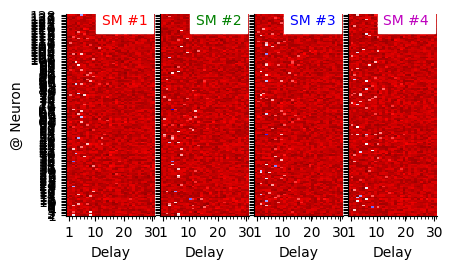

In [75]:
fig, axs = env.plot_SM(SM_hat, colors=colors, N_SM_show=4, subplotpars=subplotpars_learn)

In [76]:
Xcorr = (SM_hat[:, None, :, :] * SM_true.numpy()[:, :, None, :]).mean(axis=(0, -1))
env.opt.N_pre, Xcorr.shape, np.arange(0, env.opt.N_pre, env.opt.N_pre//4), [1] + (np.arange(0, env.opt.N_pre, env.opt.N_pre//4) + env.opt.N_pre//4).tolist(), Xcorr.max()

(128, (128, 128), array([ 0, 32, 64, 96]), [1, 32, 64, 96, 128], 0.0071105068)

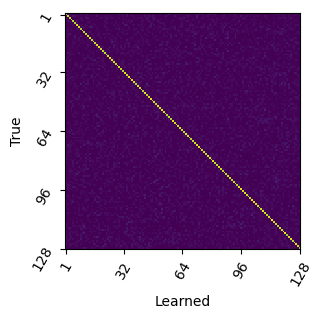

In [77]:
subplotpars_scan = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975)
fig, ax = plt.subplots(figsize=(opt_scan.fig_width, opt_scan.fig_width), subplotpars=subplotpars_scan)
ax.imshow(Xcorr, interpolation='nearest', vmin=0)

ax.set_ylabel('True')
ax.set_xlabel('Learned')

ticks = [.5] + (np.arange(0, env.opt.N_pre, env.opt.N_pre//4) + env.opt.N_pre//4 - .5).tolist()
ticklabels = [1] + (np.arange(0, env.opt.N_pre, env.opt.N_pre//4) + env.opt.N_pre//4).astype(int).tolist()
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=60)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels, rotation=60)

if not figpath is None: printfig(fig, 'THC_xcorr-supervised')